In [1]:
%load_ext watermark


In [2]:
from IPython.display import display
import pandas as pd
import seaborn as sns
from teeplot import teeplot as tp

from pylib.munge._agg_characters_extrema import agg_characters_extrema
from pylib.munge._calc_characters_from_genomes_cupy import (
    calc_characters_from_genomes_cupy,
)


In [3]:
%watermark -diwmuv -iv


Last updated: 2024-12-08T00:05:25.396559+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.5.0-1025-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

teeplot: 1.1.3
pandas : 2.2.3
seaborn: 0.13.2

Watermark: 2.4.3



In [4]:
teeplot_subdir = "cupy-denovo-spatial1d-genomes"
teeplot_subdir


'cupy-denovo-spatial1d-genomes'

## Prep Data


In [5]:
df = pd.read_parquet("https://osf.io/k87f6/download")
display(df.describe()), display(df.head()), display(df.tail());


,fitness,tile,row,col,globalSeed,nCol,nRow,nWav,nTrait,nCycle,nColSubgrid,nRowSubgrid,tilePopSize,tournSize,msec,tsc,nBen
count,1.074692e+07,1.074692e+07,1.074692e+07,1.074692e+07,1.074692e+07,10746918.0,10746918.0,10746918.0,10746918.0,10746918.0,1.074692e+07,1.074692e+07,10746918.0,1.074692e+07,10746918.0,10746918.0,1.074692e+07
mean,1.697290e+01,2.952400e+04,1.210000e+02,1.210000e+02,7.500000e+00,243.0,243.0,1.0,2.0,500000.0,1.648571e+02,1.648571e+02,256.0,1.099986e+00,0.0,0.0,1.715385e+01
std,1.099397e+01,1.704598e+04,7.014747e+01,7.014747e+01,4.031129e+00,0.0,0.0,0.0,0.0,0.0,1.063457e+02,1.063457e+02,0.0,0.000000e+00,0.0,0.0,1.116207e+01
min,-2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,243.0,243.0,1.0,2.0,500000.0,1.000000e+00,1.000000e+00,256.0,1.100000e+00,0.0,0.0,1.000000e+00
25%,1.000000e+01,1.476200e+04,6.000000e+01,6.000000e+01,4.000000e+00,243.0,243.0,1.0,2.0,500000.0,2.700000e+01,2.700000e+01,256.0,1.100000e+00,0.0,0.0,1.000000e+01
50%,1.600000e+01,2.952400e+04,1.210000e+02,1.210000e+02,7.500000e+00,243.0,243.0,1.0,2.0,500000.0,2.430000e+02,2.430000e+02,256.0,1.100000e+00,0.0,0.0,1.600000e+01
75%,2.400000e+01,4.428600e+04,1.820000e+02,1.820000e+02,1.100000e+01,243.0,243.0,1.0,2.0,500000.0,2.430000e+02,2.430000e+02,256.0,1.100000e+00,0.0,0.0,2.400000e+01
max,4.000000e+01,5.904800e+04,2.420000e+02,2.420000e+02,1.400000e+01,243.0,243.0,1.0,2.0,500000.0,2.430000e+02,2.430000e+02,256.0,1.100000e+00,0.0,0.0,4.000000e+01


,bitfield,fitness,tile,row,col,genomeFlavor,globalSeed,nCol,nRow,nWav,nTrait,nCycle,nColSubgrid,nRowSubgrid,tilePopSize,tournSize,msec,tsc,replicate,nBen
0,0200010A,2.0,0,0,0,genome_cupy_2xl_denovo_poisson,2,243,243,1,2,500000,3,3,256,1.1,0.0,0,6a21361c-25c3-416c-8747-c52e5b60b2e8,2
1,0200010A,2.0,1,1,0,genome_cupy_2xl_denovo_poisson,2,243,243,1,2,500000,3,3,256,1.1,0.0,0,6a21361c-25c3-416c-8747-c52e5b60b2e8,2
2,0200010A,2.0,2,2,0,genome_cupy_2xl_denovo_poisson,2,243,243,1,2,500000,3,3,256,1.1,0.0,0,6a21361c-25c3-416c-8747-c52e5b60b2e8,2
3,02000146,2.0,3,3,0,genome_cupy_2xl_denovo_poisson,2,243,243,1,2,500000,3,3,256,1.1,0.0,0,6a21361c-25c3-416c-8747-c52e5b60b2e8,2
4,02000146,2.0,4,4,0,genome_cupy_2xl_denovo_poisson,2,243,243,1,2,500000,3,3,256,1.1,0.0,0,6a21361c-25c3-416c-8747-c52e5b60b2e8,2


,bitfield,fitness,tile,row,col,genomeFlavor,globalSeed,nCol,nRow,nWav,nTrait,nCycle,nColSubgrid,nRowSubgrid,tilePopSize,tournSize,msec,tsc,replicate,nBen
10746913,010001DC,1.0,59044,238,242,genome_cupy_1xl_denovo_poisson,14,243,243,1,2,500000,243,243,256,1.1,0.0,0,3048e5fe-e2d6-4b31-990c-699fc019e2ec,1
10746914,010001DC,1.0,59045,239,242,genome_cupy_1xl_denovo_poisson,14,243,243,1,2,500000,243,243,256,1.1,0.0,0,3048e5fe-e2d6-4b31-990c-699fc019e2ec,1
10746915,010001DC,1.0,59046,240,242,genome_cupy_1xl_denovo_poisson,14,243,243,1,2,500000,243,243,256,1.1,0.0,0,3048e5fe-e2d6-4b31-990c-699fc019e2ec,1
10746916,010001DC,1.0,59047,241,242,genome_cupy_1xl_denovo_poisson,14,243,243,1,2,500000,243,243,256,1.1,0.0,0,3048e5fe-e2d6-4b31-990c-699fc019e2ec,1
10746917,010001DC,1.0,59048,242,242,genome_cupy_1xl_denovo_poisson,14,243,243,1,2,500000,243,243,256,1.1,0.0,0,3048e5fe-e2d6-4b31-990c-699fc019e2ec,1


In [6]:
df = calc_characters_from_genomes_cupy(df)
display(df.describe()), display(df.head()), display(df.tail());


statistic,available beneficial mutations,fitness,accrued beneficial,accrued deleterious,accrued hypermutator,founder,replicate,population size,group
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1.0746918e7,1.0746918e7,1.0746918e7,1.0746918e7,1.0746918e7,1.0746918e7,1.0746918e7,1.0746918e7,1.0746918e7
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",17.153846,16.972914,16.99118,0.018266,16.656389,127.815132,9.1824e18,9.8527e6,3119.714286
"""std""",11.162066,10.99397,11.015716,0.146632,36.122847,73.596838,5.3707e18,7.0730e6,9136.280788
"""min""",1.0,-2.0,1.0,0.0,1.0,0.0,5.6291e16,256.0,0.0
"""25%""",10.0,10.0,10.0,0.0,1.0,66.0,4.4382e18,186624.0,0.0
"""50%""",16.0,16.0,16.0,0.0,1.0,127.0,9.5762e18,1.5116544e7,0.0
"""75%""",24.0,24.0,24.0,0.0,1.0,192.0,1.3664e19,1.5116544e7,729.0
"""max""",40.0,40.0,40.0,6.0,100.0,255.0,1.8429e19,1.5116544e7,59048.0


available beneficial mutations,fitness,accrued beneficial,accrued deleterious,accrued hypermutator,founder,replicate,population size,group
i8,f32,i64,i64,i64,i64,u64,u64,u32
2,2.0,2,0,1,10,16718381540940362211,2304,0
2,2.0,2,0,1,10,16718381540940362211,2304,0
2,2.0,2,0,1,10,16718381540940362211,2304,0
2,2.0,2,0,1,70,16718381540940362211,2304,243
2,2.0,2,0,1,70,16718381540940362211,2304,243


available beneficial mutations,fitness,accrued beneficial,accrued deleterious,accrued hypermutator,founder,replicate,population size,group
i8,f32,i64,i64,i64,i64,u64,u64,u32
1,1.0,1,0,1,220,14891311509330744113,15116544,0
1,1.0,1,0,1,220,14891311509330744113,15116544,0
1,1.0,1,0,1,220,14891311509330744113,15116544,0
1,1.0,1,0,1,220,14891311509330744113,15116544,0
1,1.0,1,0,1,220,14891311509330744113,15116544,0


In [7]:
dfagg = agg_characters_extrema(df)
display(dfagg.describe()), display(dfagg.head()), display(dfagg.tail());


100%|██████████| 182/182 [00:00<00:00, 185.00it/s]


,group,replicate,population size,available beneficial mutations,min fitness,max fitness,mean fitness,median fitness,min accrued beneficial,max accrued beneficial,...,median accrued beneficial,min accrued deleterious,max accrued deleterious,mean accrued deleterious,median accrued deleterious,min accrued hypermutator,max accrued hypermutator,mean accrued hypermutator,median accrued hypermutator,founder nunique
count,863694.000000,8.636940e+05,8.636940e+05,863694.000000,863694.000000,863694.000000,863694.00000,863694.000000,863694.000000,863694.000000,...,863694.000000,863694.000000,863694.000000,863694.000000,863694.000000,863694.000000,863694.000000,863694.000000,863694.000000,863694.000000
mean,27240.309401,7.692929e+18,3.185400e+03,17.153846,15.087763,15.104597,15.10278,15.104597,15.129791,15.129791,...,15.129791,0.025194,0.042029,0.027011,0.025194,15.030771,15.074328,15.033201,15.031918,1.022603
std,17426.552869,5.588618e+18,1.771294e+05,11.162072,8.931231,8.945672,8.94389,8.945672,8.968716,8.968716,...,8.968716,0.176925,0.236769,0.177852,0.176925,34.528035,34.572723,34.528325,34.529212,1.676104
min,0.000000,5.629117e+16,2.560000e+02,1.000000,-2.000000,-2.000000,-2.00000,-2.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,11812.000000,1.832849e+18,2.560000e+02,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,...,10.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,25829.500000,5.842776e+18,2.560000e+02,16.000000,16.000000,16.000000,16.00000,16.000000,16.000000,16.000000,...,16.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,42439.000000,1.248720e+19,2.560000e+02,24.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,...,20.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,59048.000000,1.842861e+19,1.511654e+07,40.000000,40.000000,40.000000,40.00000,40.000000,40.000000,40.000000,...,40.000000,4.000000,6.000000,4.000000,4.000000,100.000000,100.000000,100.000000,100.000000,236.000000


,group,replicate,population size,available beneficial mutations,min fitness,max fitness,mean fitness,median fitness,min accrued beneficial,max accrued beneficial,...,median accrued beneficial,min accrued deleterious,max accrued deleterious,mean accrued deleterious,median accrued deleterious,min accrued hypermutator,max accrued hypermutator,mean accrued hypermutator,median accrued hypermutator,founder nunique
0,9964,16718381540940362211,2304,2,2.0,2.0,2.0,2.0,2,2,...,2.0,0,0,0.0,0.0,1,1,1.0,1.0,1
1,8280,16718381540940362211,2304,2,2.0,2.0,2.0,2.0,2,2,...,2.0,0,0,0.0,0.0,1,1,1.0,1.0,1
2,15124,16718381540940362211,2304,2,2.0,2.0,2.0,2.0,2,2,...,2.0,0,0,0.0,0.0,1,1,1.0,1.0,1
3,13642,16718381540940362211,2304,2,2.0,2.0,2.0,2.0,2,2,...,2.0,0,0,0.0,0.0,1,1,1.0,1.0,1
4,10525,16718381540940362211,2304,2,2.0,2.0,2.0,2.0,2,2,...,2.0,0,0,0.0,0.0,1,1,1.0,1.0,1


,group,replicate,population size,available beneficial mutations,min fitness,max fitness,mean fitness,median fitness,min accrued beneficial,max accrued beneficial,...,median accrued beneficial,min accrued deleterious,max accrued deleterious,mean accrued deleterious,median accrued deleterious,min accrued hypermutator,max accrued hypermutator,mean accrued hypermutator,median accrued hypermutator,founder nunique
863689,0,12304133092625784389,15116544,1,0.0,1.0,0.999085,1.0,1,1,...,1.0,0,1,0.000914,0.0,1,100,1.013413,1.0,223
863690,0,4842461504279546462,15116544,1,0.0,1.0,0.999272,1.0,1,1,...,1.0,0,1,0.000728,0.0,1,100,1.010059,1.0,222
863691,0,9521663507959764650,15116544,1,0.0,1.0,0.998815,1.0,1,1,...,1.0,0,1,0.001185,0.0,1,100,1.015089,1.0,221
863692,0,2373429189982824091,15116544,1,0.0,1.0,0.999221,1.0,1,1,...,1.0,0,1,0.000779,0.0,1,100,1.011736,1.0,228
863693,0,14891311509330744113,15116544,1,0.0,1.0,0.998950,1.0,1,1,...,1.0,0,1,0.001050,0.0,1,100,1.013413,1.0,228


## Unaccrued Beneficial Mutations


In [8]:
df_long = pd.melt(
    dfagg,
    id_vars=[
        "available beneficial mutations",
        "population size",
    ],
    value_vars=["min accrued beneficial", "max accrued beneficial"],
    var_name="extrema",
    value_name="accrued beneficial",
)
df_long["unaccrued beneficial"] = (
    df_long["available beneficial mutations"] - df_long["accrued beneficial"]
)
df_long["has any unaccrued\nbeneficial mutations"] = (
    df_long["unaccrued beneficial"] > 0
)
df_long["available beneficial\nmutations"] = (
    df_long["available beneficial mutations"]
)
display(df_long.describe()), display(df_long.head()), display(df_long.tail());


,available beneficial mutations,population size,accrued beneficial,unaccrued beneficial,available beneficial\nmutations
count,1.727388e+06,1.727388e+06,1.727388e+06,1.727388e+06,1.727388e+06
mean,1.715385e+01,3.185400e+03,1.512979e+01,2.024055e+00,1.715385e+01
std,1.116207e+01,1.771294e+05,8.968713e+00,4.910379e+00,1.116207e+01
min,1.000000e+00,2.560000e+02,1.000000e+00,0.000000e+00,1.000000e+00
25%,1.000000e+01,2.560000e+02,1.000000e+01,0.000000e+00,1.000000e+01
50%,1.600000e+01,2.560000e+02,1.600000e+01,0.000000e+00,1.600000e+01
75%,2.400000e+01,2.560000e+02,2.000000e+01,0.000000e+00,2.400000e+01
max,4.000000e+01,1.511654e+07,4.000000e+01,3.400000e+01,4.000000e+01


,available beneficial mutations,population size,extrema,accrued beneficial,unaccrued beneficial,has any unaccrued\nbeneficial mutations,available beneficial\nmutations
0,2,2304,min accrued beneficial,2,0,False,2
1,2,2304,min accrued beneficial,2,0,False,2
2,2,2304,min accrued beneficial,2,0,False,2
3,2,2304,min accrued beneficial,2,0,False,2
4,2,2304,min accrued beneficial,2,0,False,2


,available beneficial mutations,population size,extrema,accrued beneficial,unaccrued beneficial,has any unaccrued\nbeneficial mutations,available beneficial\nmutations
1727383,1,15116544,max accrued beneficial,1,0,False,1
1727384,1,15116544,max accrued beneficial,1,0,False,1
1727385,1,15116544,max accrued beneficial,1,0,False,1
1727386,1,15116544,max accrued beneficial,1,0,False,1
1727387,1,15116544,max accrued beneficial,1,0,False,1


teeplots/cupy-denovo-spatial1d-genomes/col=population-size+hue=extrema+k-depth=full+kind=boxen+viz=catplot+x=available-beneficial-mutations+y=unaccrued-beneficial+ext=.pdf
teeplots/cupy-denovo-spatial1d-genomes/col=population-size+hue=extrema+k-depth=full+kind=boxen+viz=catplot+x=available-beneficial-mutations+y=unaccrued-beneficial+ext=.png


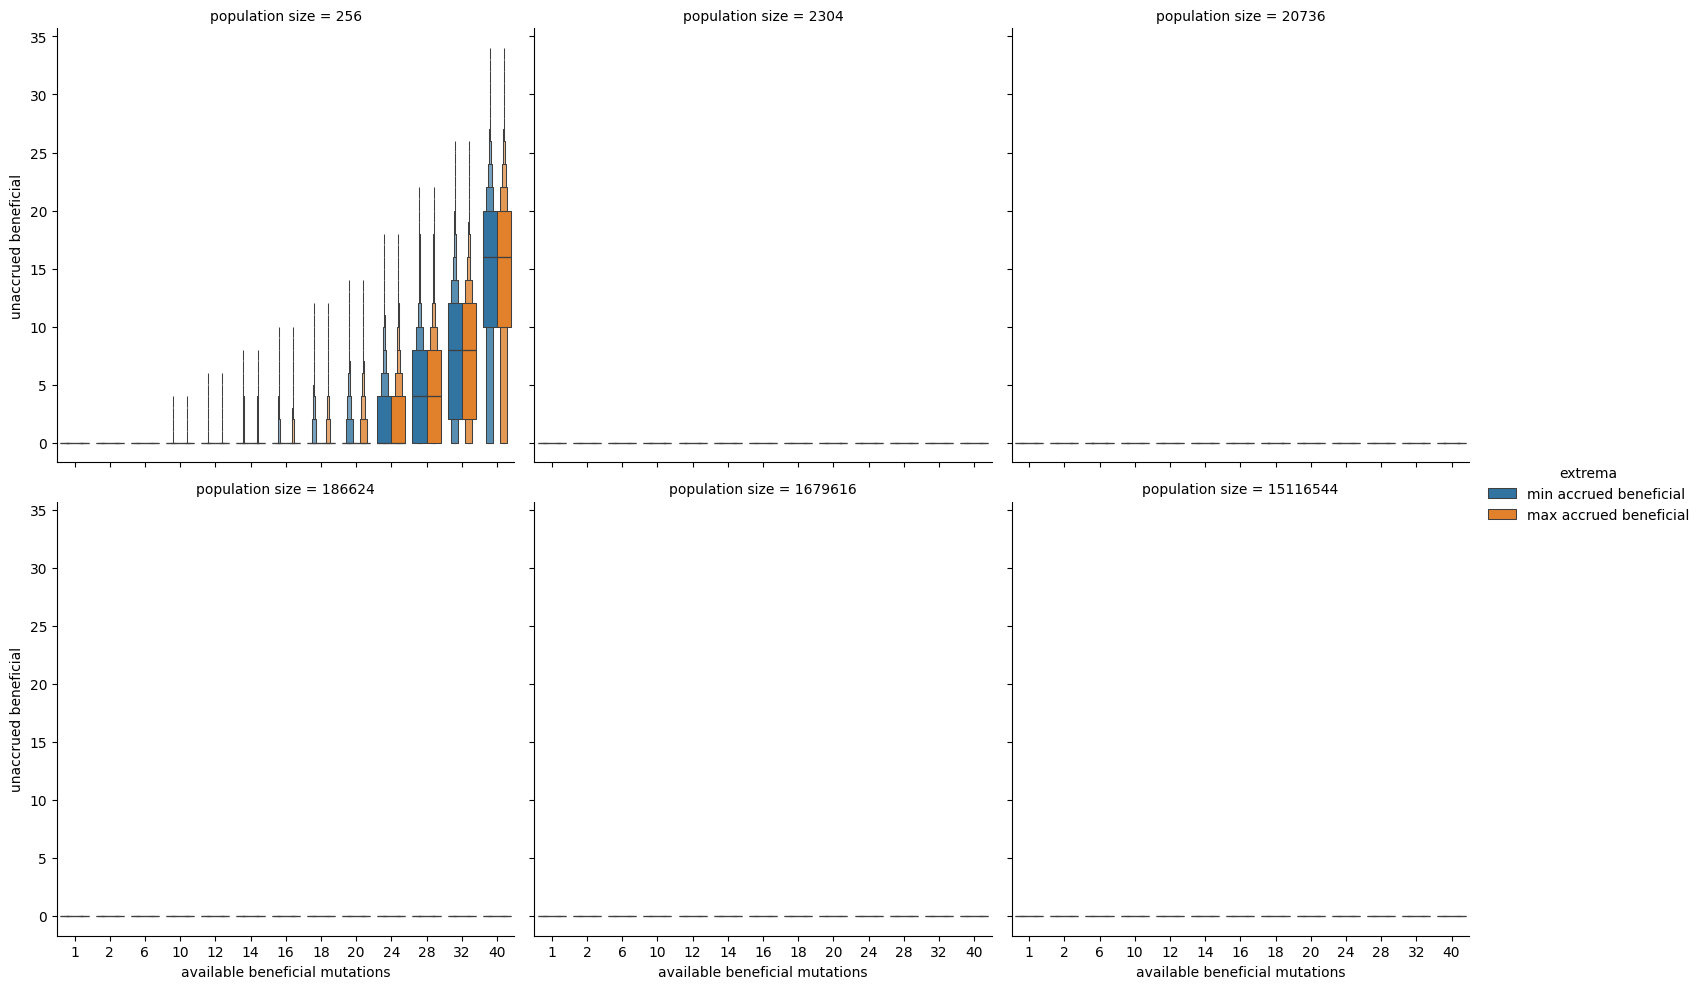

In [9]:
tp.tee(
    sns.catplot,
    data=df_long,
    x="available beneficial mutations",
    y="unaccrued beneficial",
    hue="extrema",
    col="population size",
    col_wrap=3,
    kind="boxen",
    k_depth="full",
    seed=1,
    teeplot_subdir=teeplot_subdir,
)


teeplots/cupy-denovo-spatial1d-genomes/col=available-beneficial-mutations+hue=has-any-unaccrued-beneficial-mutations+multiple=fill+palette=accent+viz=displot+x=population-size+ext=.pdf
teeplots/cupy-denovo-spatial1d-genomes/col=available-beneficial-mutations+hue=has-any-unaccrued-beneficial-mutations+multiple=fill+palette=accent+viz=displot+x=population-size+ext=.png


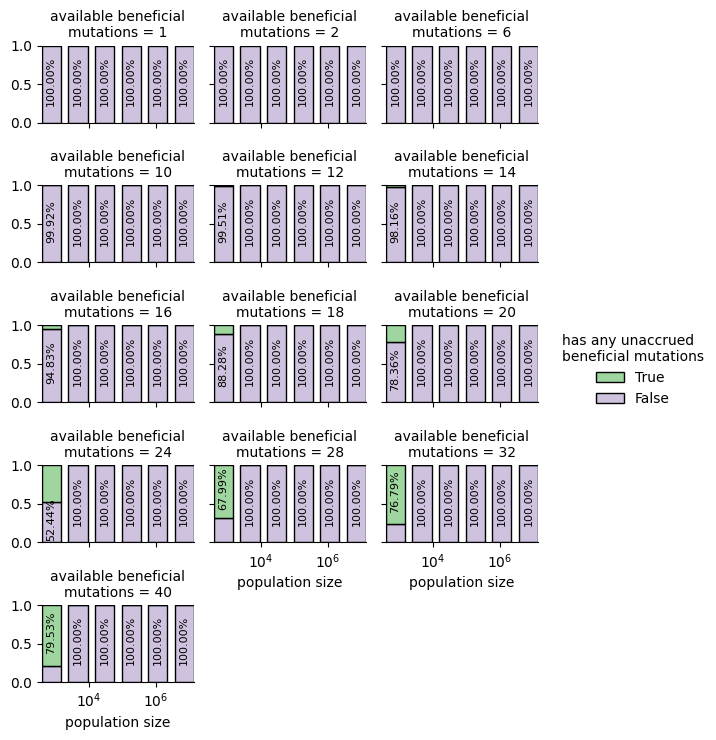

In [10]:
fildf = df_long[
    df_long["extrema"] == "max accrued beneficial"
].copy().reset_index(drop=True)

saveit, teed = tp.tee(
    sns.displot,
    data=fildf,
    x="population size",
    hue="has any unaccrued\nbeneficial mutations",
    hue_order=[True, False],
    col="available beneficial\nmutations",
    col_wrap=3,
    aspect=1.3,
    height=1.5,
    multiple="fill",
    bins=fildf["population size"].nunique(),
    log_scale=(True, False),
    shrink=0.8,
    palette="Accent",
    teeplot_callback=True,
    teeplot_subdir=teeplot_subdir,
)

teed.set_titles(col_template="{col_var} = {col_name:.0f}")
teed.set_ylabels("")
# adapted from https://stackoverflow.com/a/68850867
for ax in teed.axes.ravel():
    # add annotations
    for c in ax.containers:
        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [
            f"{w * 100:0.2f}%" if (w := v.get_height()) > 0.5 else ""
            for v in c
        ]
        ax.bar_label(
            c,
            labels=labels,
            label_type="center",
            fontsize=8,
            rotation=90,
            padding=2
        )

saveit()


## Accrued Deleterious Mutations


In [11]:
df_long = pd.melt(
    dfagg,
    id_vars=[
        "available beneficial mutations",
        "population size",
    ],
    value_vars=["min accrued deleterious", "max accrued deleterious"],
    var_name="extrema",
    value_name="acc del",
)
df_long["avlbm"] = df_long["available beneficial mutations"]
display(df_long.describe()), display(df_long.head()), display(df_long.tail());


,available beneficial mutations,population size,acc del,avlbm
count,1.727388e+06,1.727388e+06,1.727388e+06,1.727388e+06
mean,1.715385e+01,3.185400e+03,3.361144e-02,1.715385e+01
std,1.116207e+01,1.771294e+05,2.091696e-01,1.116207e+01
min,1.000000e+00,2.560000e+02,0.000000e+00,1.000000e+00
25%,1.000000e+01,2.560000e+02,0.000000e+00,1.000000e+01
50%,1.600000e+01,2.560000e+02,0.000000e+00,1.600000e+01
75%,2.400000e+01,2.560000e+02,0.000000e+00,2.400000e+01
max,4.000000e+01,1.511654e+07,6.000000e+00,4.000000e+01


,available beneficial mutations,population size,extrema,acc del,avlbm
0,2,2304,min accrued deleterious,0,2
1,2,2304,min accrued deleterious,0,2
2,2,2304,min accrued deleterious,0,2
3,2,2304,min accrued deleterious,0,2
4,2,2304,min accrued deleterious,0,2


,available beneficial mutations,population size,extrema,acc del,avlbm
1727383,1,15116544,max accrued deleterious,1,1
1727384,1,15116544,max accrued deleterious,1,1
1727385,1,15116544,max accrued deleterious,1,1
1727386,1,15116544,max accrued deleterious,1,1
1727387,1,15116544,max accrued deleterious,1,1


teeplots/cupy-denovo-spatial1d-genomes/col=extrema+k-depth=full+kind=boxen+row=avlbm+viz=catplot+x=population-size+y=acc-del+ext=.pdf
teeplots/cupy-denovo-spatial1d-genomes/col=extrema+k-depth=full+kind=boxen+row=avlbm+viz=catplot+x=population-size+y=acc-del+ext=.png


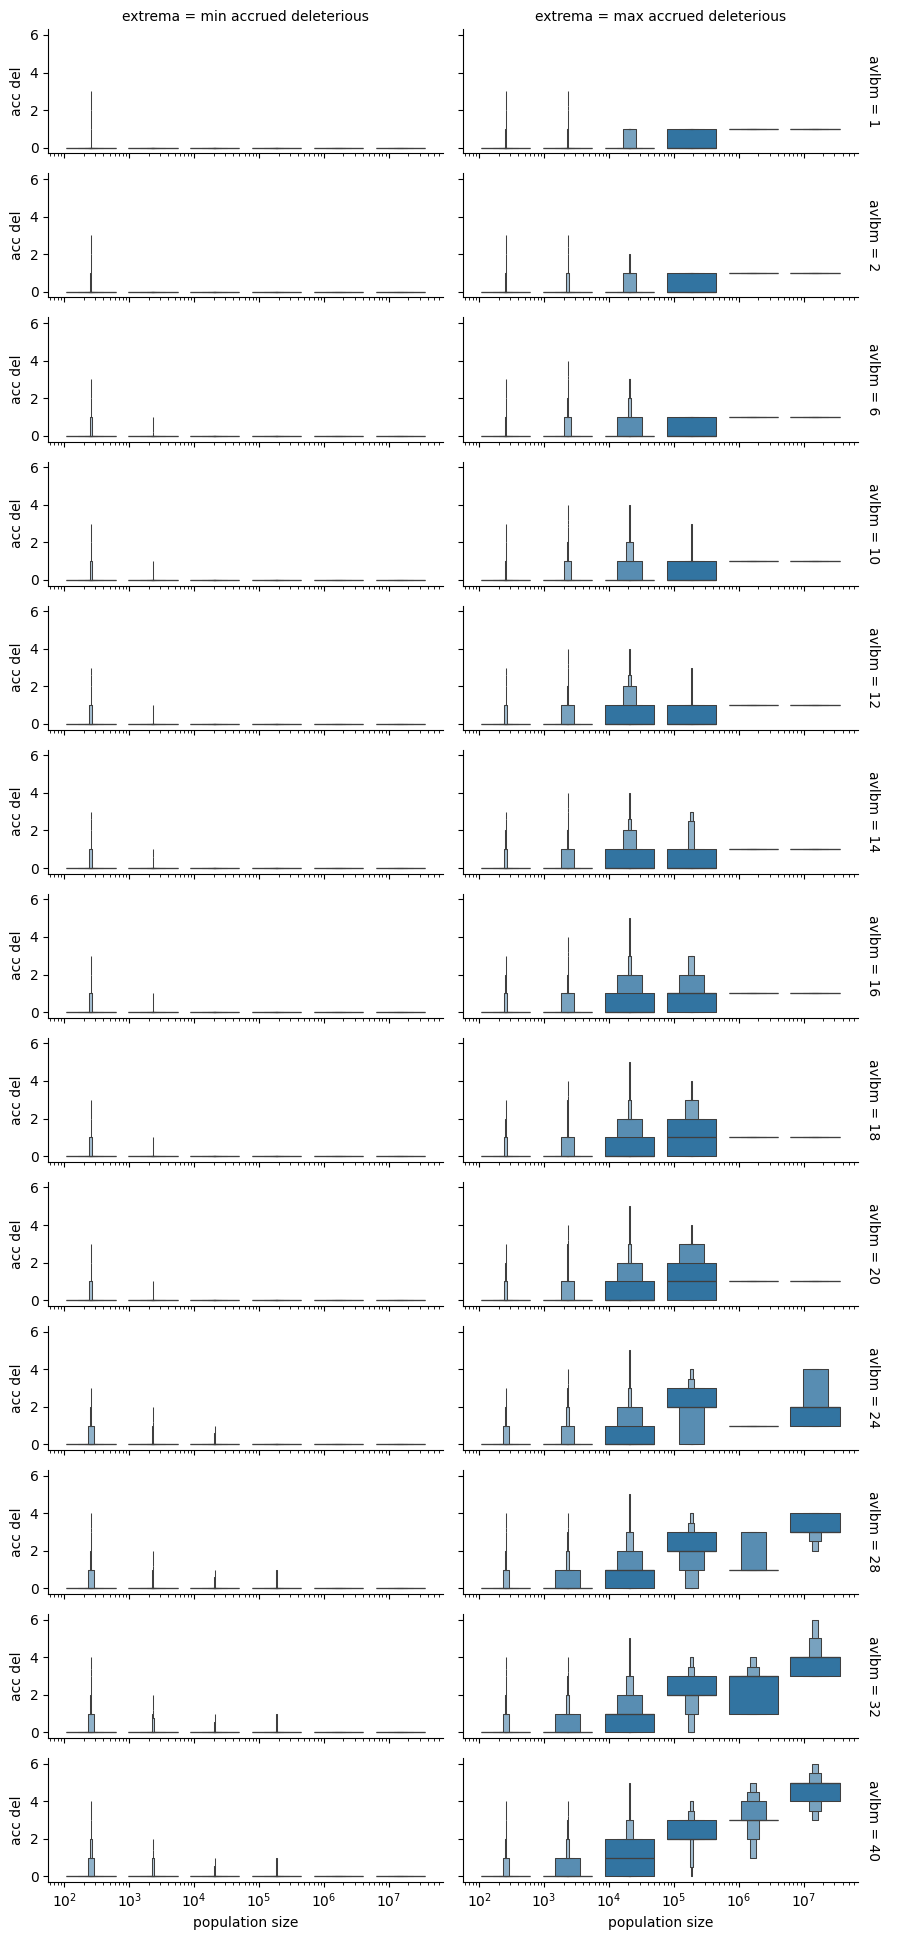

In [12]:
tp.tee(
    sns.catplot,
    data=df_long,
    x="population size",
    y="acc del",
    col="extrema",
    row="avlbm",
    aspect=3,
    height=1.5,
    kind="boxen",
    k_depth="full",
    margin_titles=True,
    native_scale=True,
    log_scale=(True, False),
    seed=1,
    teeplot_subdir=teeplot_subdir,
)


## Fitness


In [13]:
dfp = df.to_pandas()
gby = dfp.groupby(
    "replicate",
)
dfsamp = pd.concat(
    [
        gby.sample(n=100, random_state=1),
        dfp.loc[gby["fitness"].idxmax()],
        dfp.loc[gby["fitness"].idxmin()],
    ],
    ignore_index=True,
)
display(dfsamp.describe()), display(dfsamp.head()), display(dfsamp.tail());


,available beneficial mutations,fitness,accrued beneficial,accrued deleterious,accrued hypermutator,founder,replicate,population size,group
count,18564.000000,18564.000000,18564.000000,18564.000000,18564.000000,18564.000000,1.856400e+04,1.856400e+04,18564.000000
mean,17.153846,16.947479,16.985725,0.038246,16.950711,126.820782,9.182450e+18,9.852745e+06,3110.985671
std,11.162367,10.987844,11.014189,0.292561,36.397343,73.602018,5.370876e+18,7.073143e+06,9168.147689
min,1.000000,-2.000000,1.000000,0.000000,1.000000,0.000000,5.629117e+16,2.560000e+02,0.000000
25%,10.000000,10.000000,10.000000,0.000000,1.000000,65.000000,4.438189e+18,1.866240e+05,0.000000
50%,16.000000,16.000000,16.000000,0.000000,1.000000,125.000000,9.548907e+18,1.511654e+07,0.000000
75%,24.000000,24.000000,24.000000,0.000000,1.000000,191.000000,1.366443e+19,1.511654e+07,499.250000
max,40.000000,40.000000,40.000000,6.000000,100.000000,255.000000,1.842861e+19,1.511654e+07,59041.000000


,available beneficial mutations,fitness,accrued beneficial,accrued deleterious,accrued hypermutator,founder,replicate,population size,group
0,14,14.0,14,0,1,66,56291166124697857,20736,5116
1,14,14.0,14,0,1,75,56291166124697857,20736,5842
2,14,14.0,14,0,1,153,56291166124697857,20736,5609
3,14,14.0,14,0,1,96,56291166124697857,20736,3425
4,14,14.0,14,0,1,19,56291166124697857,20736,3902


,available beneficial mutations,fitness,accrued beneficial,accrued deleterious,accrued hypermutator,founder,replicate,population size,group
18559,14,13.0,14,1,1,239,18076101192176605995,15116544,0
18560,6,5.0,6,1,1,75,18243710932598814261,15116544,0
18561,28,24.0,28,4,100,105,18293933644732289086,186624,1947
18562,18,14.0,18,4,100,77,18370657254749698733,2304,10022
18563,40,36.0,40,4,100,105,18428614679446829519,186624,1947


teeplots/cupy-denovo-spatial1d-genomes/hue=available-beneficial-mutations+k-depth=full+kind=boxen+viz=catplot+x=population-size+y=fitness+ext=.pdf
teeplots/cupy-denovo-spatial1d-genomes/hue=available-beneficial-mutations+k-depth=full+kind=boxen+viz=catplot+x=population-size+y=fitness+ext=.png


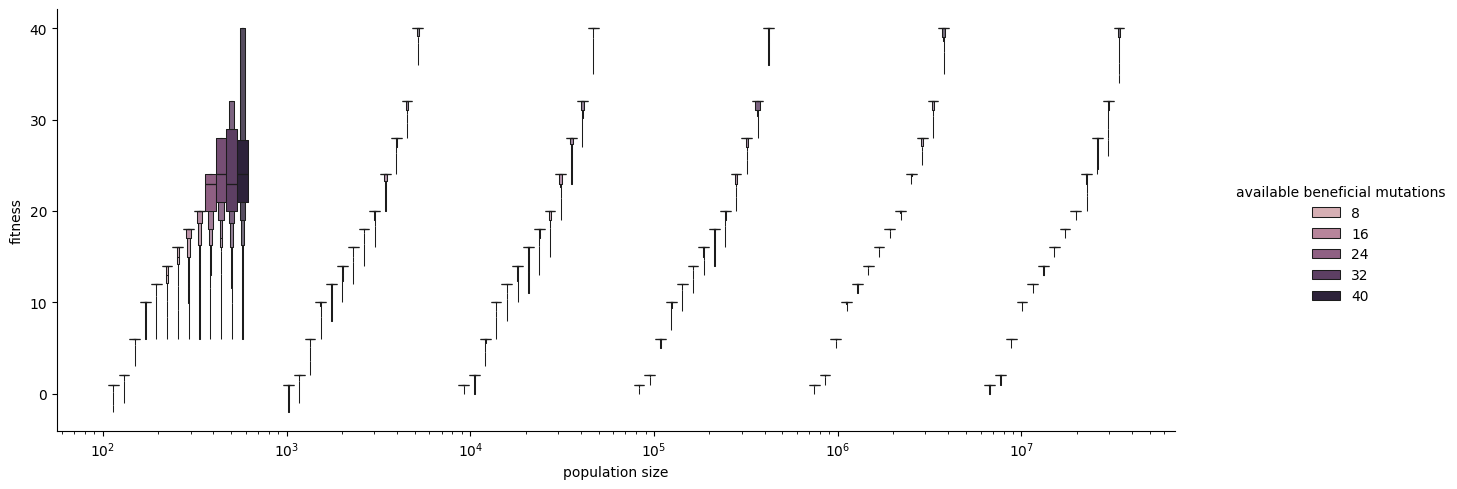

In [14]:
tp.tee(
    sns.catplot,
    data=dfsamp,
    x="population size",
    y="fitness",
    hue="available beneficial mutations",
    aspect=2.5,
    kind="boxen",
    k_depth="full",
    margin_titles=True,
    native_scale=True,
    log_scale=(True, False),
    seed=1,
    teeplot_subdir=teeplot_subdir,
)


## Num Unique Founders


teeplots/cupy-denovo-spatial1d-genomes/hue=available-beneficial-mutations+k-depth=full+kind=boxen+viz=catplot+x=population-size+y=founder-nunique+ext=.pdf
teeplots/cupy-denovo-spatial1d-genomes/hue=available-beneficial-mutations+k-depth=full+kind=boxen+viz=catplot+x=population-size+y=founder-nunique+ext=.png


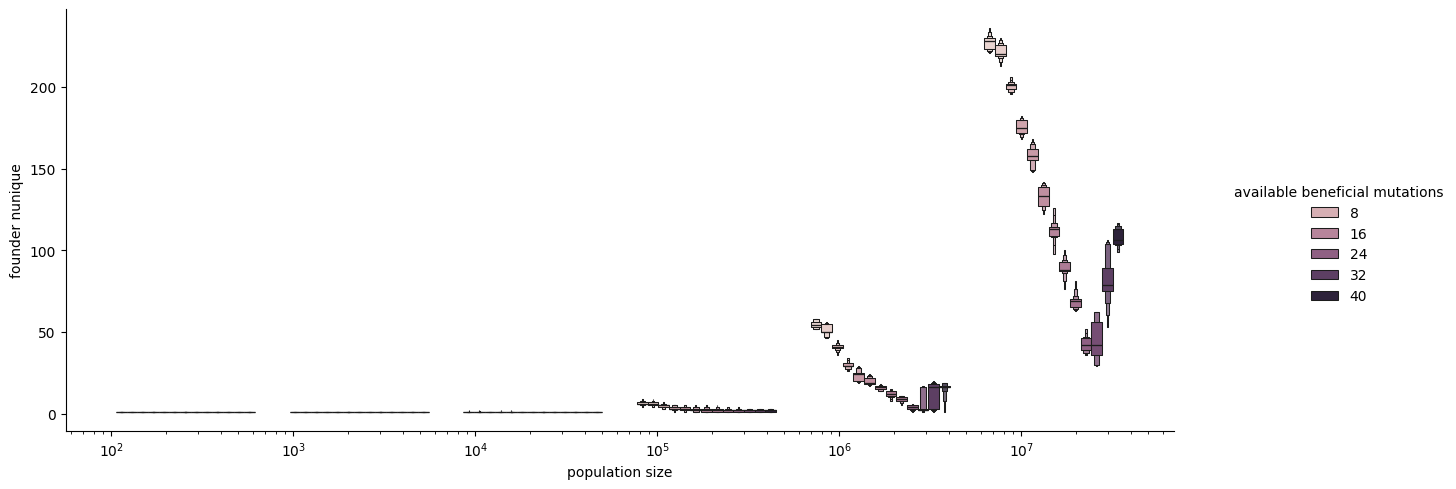

In [15]:
tp.tee(
    sns.catplot,
    data=dfagg,
    x="population size",
    y="founder nunique",
    hue="available beneficial mutations",
    aspect=2.5,
    kind="boxen",
    k_depth="full",
    margin_titles=True,
    native_scale=True,
    log_scale=(True, False),
    seed=1,
    teeplot_subdir=teeplot_subdir,
)


## Hypermutator


teeplots/cupy-denovo-spatial1d-genomes/col=available-beneficial-mutations+kind=strip+viz=catplot+x=population-size+y=mean-accrued-hypermutator+ext=.pdf
teeplots/cupy-denovo-spatial1d-genomes/col=available-beneficial-mutations+kind=strip+viz=catplot+x=population-size+y=mean-accrued-hypermutator+ext=.png


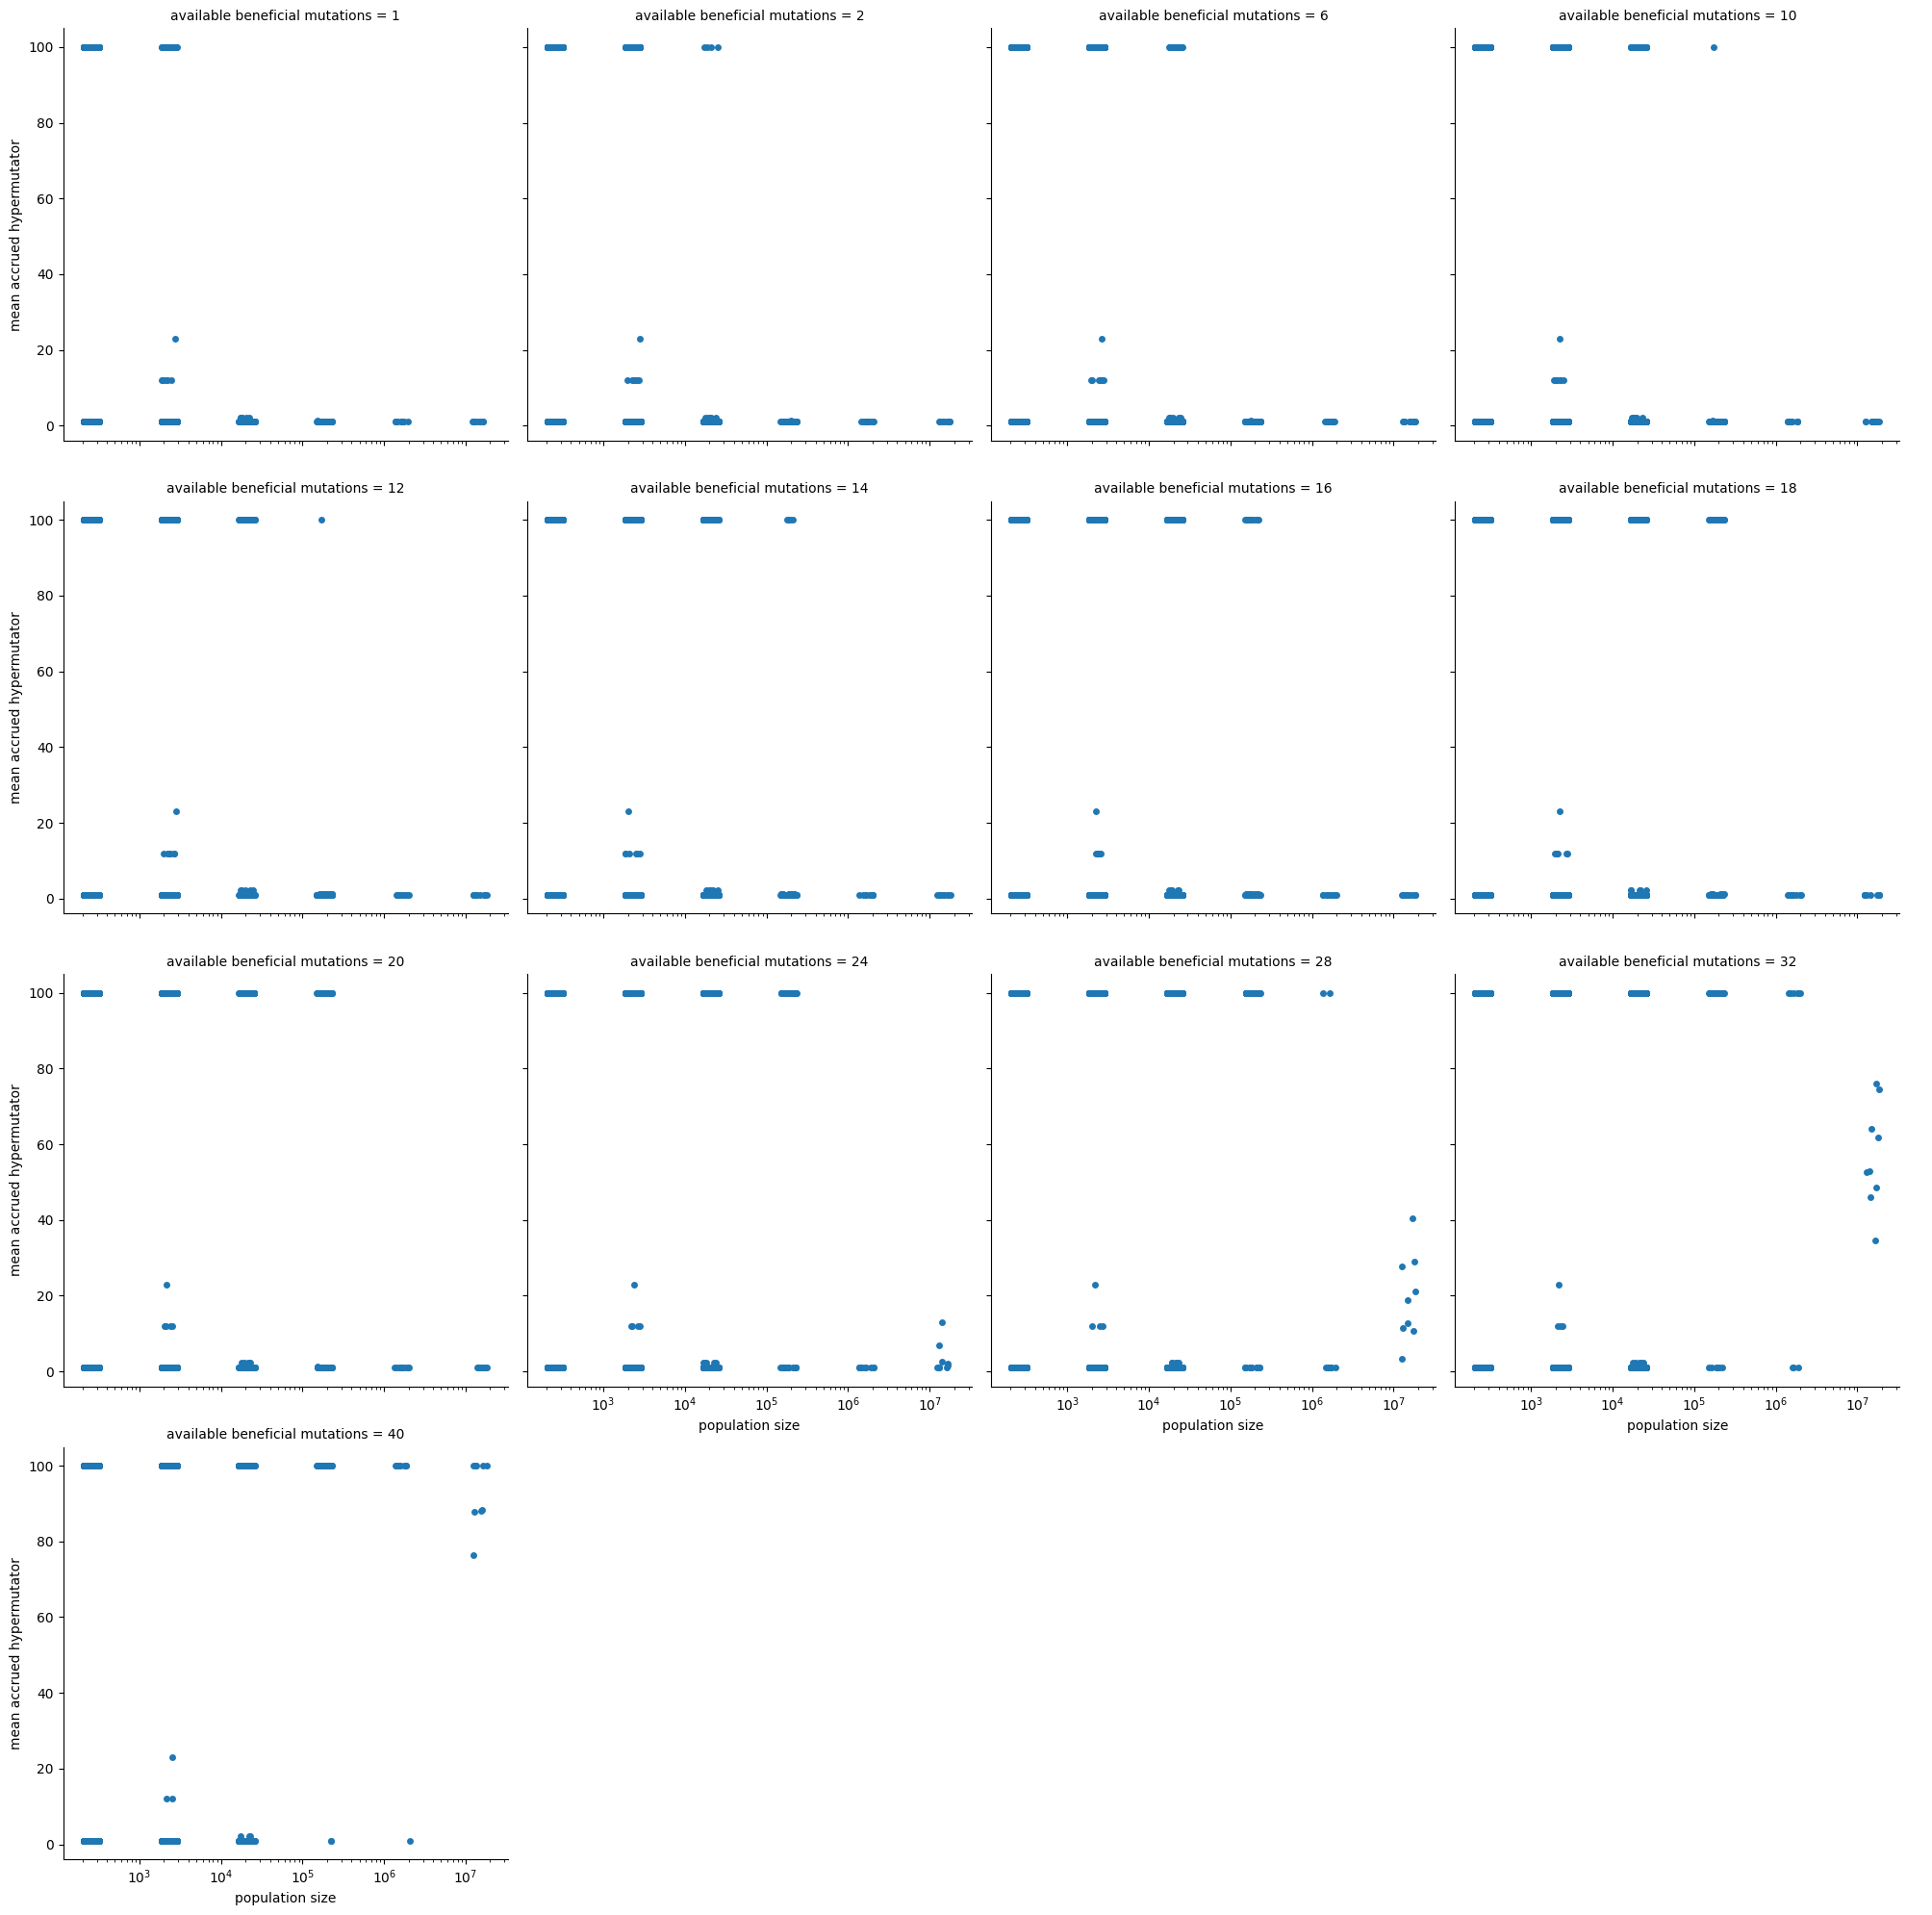

In [16]:
tp.tee(
    sns.catplot,
    data=dfagg,
    x="population size",
    y="mean accrued hypermutator",
    col="available beneficial mutations",
    col_wrap=4,
    kind="strip",
    legend_out=True,
    margin_titles=True,
    native_scale=True,
    log_scale=(True, False),
    seed=1,
    teeplot_subdir=teeplot_subdir,
)


teeplots/cupy-denovo-spatial1d-genomes/hue=available-beneficial-mutations+kind=bar+viz=catplot+x=population-size+y=mean-accrued-hypermutator+ext=.pdf
teeplots/cupy-denovo-spatial1d-genomes/hue=available-beneficial-mutations+kind=bar+viz=catplot+x=population-size+y=mean-accrued-hypermutator+ext=.png


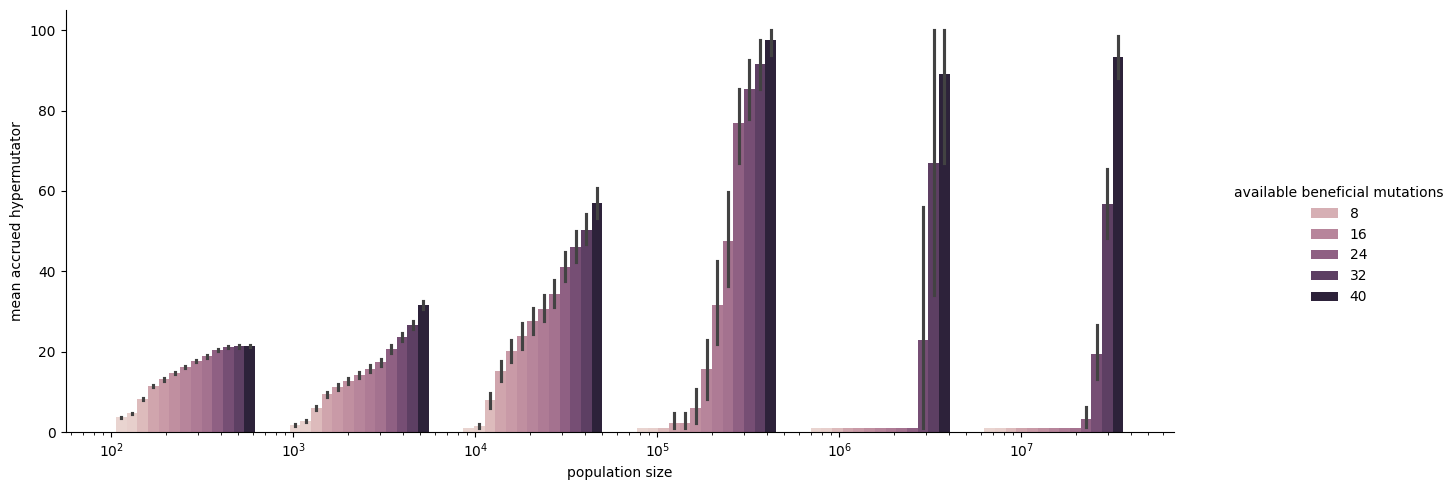

In [17]:
tp.tee(
    sns.catplot,
    data=dfagg,
    x="population size",
    y="mean accrued hypermutator",
    hue="available beneficial mutations",
    aspect=2.5,
    kind="bar",
    margin_titles=True,
    native_scale=True,
    log_scale=(True, False),
    seed=1,
    teeplot_subdir=teeplot_subdir,
)
